## Thin Shock Layer Theory for assumed shockwave of $ y = \sqrt{x/2} $

/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/1900107593.py:25: RuntimeWarning: divide by zero encountered in divide
  gradient = 1/(2*np.sqrt(x_values))
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/1900107593.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  df.at[i, column_name]["beta'"] = math.atan(1/(4*height_y_behindshock)) #convert gradient to angle, beta right behind shockwave
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/1900107593.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.019220537227280184' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'y_b'] = y_b
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/1900107593.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.021629969642433727' ha

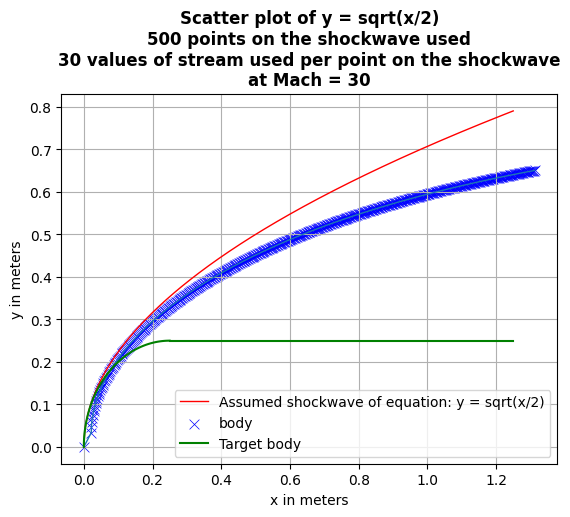

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pprint

rho_inf = 0.0886
M = 30
gamma = 1.4
r = 287
T_inf = 216.65
v_inf = M*math.sqrt(gamma*r*T_inf)
p_inf = 5480
s_inf = 710.57 #J/mol/K
cp = 1005 #J/kg/K
r = 287.05 #J/kg/K
limit = 1.25

#definition of phi_values, gradient, shock_angle
num_points_shock = 500
num_points_phi = 30
x_values = np.linspace(0, limit, num_points_shock)
y_values = np.sqrt(x_values/2)
gradient = 1/(2*np.sqrt(x_values))
shock_angle = np.arctan(gradient) #in radians
phi_order = [num_points_phi,]+[i for i in range(1,num_points_phi)]
phi_values = [[{"value of phi": j*(y_values[i]*v_inf*rho_inf)/num_points_phi} for j in phi_order] 
              for i in range(num_points_shock)] #each column represents a unique streamline
df_phi_values = pd.DataFrame(phi_values)
new_column_names = [f"phi{i+1}" for i in range(len(df_phi_values.columns))]  # Generate new column names
df_phi_values.columns = new_column_names
# print(df_phi_values.iloc[45,23]['value of phi']) #remember that indices are zero based
df = pd.DataFrame({
    'x': x_values,
    'y': y_values,
    'gradient': gradient,
    'shock_angle': shock_angle,
})
df = pd.concat([df, df_phi_values], axis=1)

#definition of u and pressure values
df['u'] = [v_inf*math.cos(i) for i in df['shock_angle']] #in radians
df['p1'] = [p_inf*(1+2*gamma*(M**2*(math.sin(a))**2-1)/(gamma+1)) for a in df['shock_angle']]
df['Rs'] = [abs(((4 * x) ** (3 / 2))*((1+ 1/(8*x))**(3 / 2)) if x != 0 else float('inf')) for x in df['x']]
df['rho_1'] = [rho_inf*(1+((gamma+1)*M**2*(math.sin(a))**2)/((gamma-1)*M**2*(math.sin(a))**2+2)) for a in df['shock_angle']]
df['T1'] = [T_inf*(1+2*gamma*(M**2*(math.sin(a))**2-1)/(gamma+1))/((1+((gamma+1)*M**2*(math.sin(a))**2)/((gamma-1)*M**2*(math.sin(a))**2+2))) for a in df['shock_angle']]

#define columns filled with 0 for y_b and column for x and y coordinate of body grid
df['y_b'] = 0
df['x_body'] = 0
df['y_body'] = 0

for i in range(num_points_shock):
    phi_1 = df.at[i, 'phi1']['value of phi']
    u1 = df.at[i, 'u']
    Rs = df.at[i, 'Rs']
    p1 = df.at[i, 'p1']
    rho_1 = df.at[i, 'rho_1']
    angle_at_point1 = df.at[i, 'shock_angle']
    x_at_point1 = df.at[i, 'x']
    y_at_point1 = df.at[i, 'y']
    for j in range(2,num_points_phi+1):
        column_name = f'phi{j}'  
      
        phi_j = df.at[i, column_name]['value of phi']        
        df.at[i, column_name][f"p{j}"] = p1 + (u1/Rs)*(phi_j - phi_1) #add new pressure grid values
        p = df.at[i, column_name][f"p{j}"]
        df.at[i, column_name]["height_y'"] = df.at[i, column_name]['value of phi']/rho_inf/v_inf #add new height grid values y,corresponding to point on the shockwave
        height_y_behindshock = df.at[i, column_name]["height_y'"]
        df.at[i, column_name]["beta'"] = math.atan(1/(4*height_y_behindshock)) #convert gradient to angle, beta right behind shockwave
        beta = df.at[i, column_name]["beta'"]
        df.at[i, column_name]["p'_behind_shock"] = p_inf*(1+2*gamma*(M**2*(math.sin(beta))**2-1)/(gamma+1))
        df.at[i, column_name]["T'_behind_shock"] = T_inf*(1+2*gamma*(M**2*(math.sin(beta))**2-1)/(gamma+1))/((1+((gamma+1)*M**2*(math.sin(beta))**2)/((gamma-1)*M**2*(math.sin(beta))**2+2)))
        p_prime = df.at[i, column_name]["p'_behind_shock"]
        T_prime = df.at[i, column_name]["T'_behind_shock"]
        df.at[i, column_name]["delta_s"] = cp*math.log(T_prime/T_inf)-(r*math.log(p_prime/p_inf))
        delta_s = df.at[i, column_name]["delta_s"]

        #Defining temperature and density and velocities for each grid point using enthalpy relations
        df.at[i, column_name][f"T{j}"] = T_inf*math.exp((delta_s+r*math.log(p/p_inf))/cp)
        T = df.at[i, column_name][f"T{j}"]
        df.at[i, column_name][f"rho{j}"] = p/(r*T)
        rho = df.at[i, column_name][f"rho{j}"]
        u_grid = math.sqrt(2*(cp*(T_inf-T)+(v_inf**2)/2))
        df.at[i, column_name][f"u{j}"] = u_grid
        df.at[i, column_name][f"1/(rho*u{j})"] = 1/(math.sqrt(2*(cp*(T_inf-T)+(v_inf**2)/2))*rho)
    
    #Calculate y_b the distance between shock wave and body
    grid_y = [1/(u1*rho_1),]+[df.at[i, f"phi{k}"][f"1/(rho*u{k})"] for k in range(2,num_points_phi+1)]
    grid_x = [phi_1,] + [df.at[i, f"phi{k}"]["value of phi"] for k in range(2,num_points_phi+1)]
    y_b = abs(np.trapz(grid_y, grid_x))
    df.at[i, 'y_b'] = y_b
    #definition of body grid
    df.at[i, 'x_body'] = x_at_point1 + y_b*math.sin(angle_at_point1)
    df.at[i, 'y_body'] = y_at_point1 - y_b*math.cos(angle_at_point1)

#save data to csv file: 
df.to_csv('data1.csv', index=False)

############################################
##################PLOTTING##################
############################################
# Create scatter plot of shockwave
x_shock_forplotonly = np.linspace(0, limit, num_points_shock)
y_shock_forplotonly = np.sqrt(x_values/2)
plt.plot(x_shock_forplotonly, y_shock_forplotonly, color='red', linewidth=1, label='Assumed shockwave of equation: y = sqrt(x/2)')
# Create scatter plot of body
plt.scatter(df['x_body'], df['y_body'], color='blue', s=50, marker='x', label='body', linewidths=0.5)
plt.plot(df['x_body'], df['y_body'], linestyle='-', linewidth=1)
# plt.text(0.5, 1.5, f'{num_points_shock} points on the shockwave used\n{num_points_phi} values of stream used per point on the shockwave', fontsize=12, ha='center', va='center')
#plot target body
center_x, center_y = 0.25, 0
radius = 0.25
theta = np.linspace(0, np.pi / 2, 100)
x_circle = center_x - radius * np.cos(theta)
y_circle = center_y + radius * np.sin(theta)
x_line = [0.25, 1.25]
y_line = [0.25, 0.25]
plt.plot(x_circle, y_circle, label='Target body', color='green')
plt.plot(x_line, y_line, color='green')

plt.xlabel('x in meters')
plt.ylabel('y in meters')
plt.title('Scatter plot of y = sqrt(x/2)'+'\n'+f'{num_points_shock} points on the shockwave used\n{num_points_phi} values of stream used per point on the shockwave'+'\n'+f'at Mach = {M}', weight='bold')
plt.legend()
plt.grid(True)
plt.show()

## Thin Shock Layer Theory for assumed shockwave of $ y = \sqrt{x} $

/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/3765097382.py:25: RuntimeWarning: divide by zero encountered in divide
  gradient = 1/(2*np.sqrt(x_values))
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/3765097382.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  df.at[i, column_name]["beta'"] = math.atan(1/(2*height_y_behindshock)) #convert gradient to angle, beta right behind shockwave
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/3765097382.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0270589981412569' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'y_b'] = y_b
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/3765097382.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.029429452388875597' has 

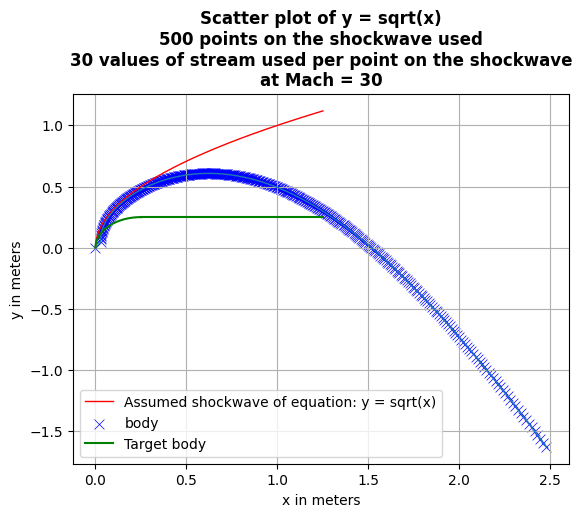

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pprint

rho_inf = 0.0886
M = 30
gamma = 1.4
r = 287
T_inf = 216.65
v_inf = M*math.sqrt(gamma*r*T_inf)
p_inf = 5480
s_inf = 710.57 #J/mol/K
cp = 1005 #J/kg/K
r = 287.05 #J/kg/K
limit = 1.25

#definition of phi_values, gradient, shock_angle
num_points_shock = 500
num_points_phi = 30
x_values = np.linspace(0, limit, num_points_shock)
y_values = np.sqrt(x_values)
gradient = 1/(2*np.sqrt(x_values))
shock_angle = np.arctan(gradient) #in radians
phi_order = [num_points_phi,]+[i for i in range(1,num_points_phi)]
phi_values = [[{"value of phi": j*(y_values[i]*v_inf*rho_inf)/num_points_phi} for j in phi_order] 
              for i in range(num_points_shock)] #each column represents a unique streamline
df_phi_values = pd.DataFrame(phi_values)
new_column_names = [f"phi{i+1}" for i in range(len(df_phi_values.columns))]  # Generate new column names
df_phi_values.columns = new_column_names
# print(df_phi_values.iloc[45,23]['value of phi']) #remember that indices are zero based
df = pd.DataFrame({
    'x': x_values,
    'y': y_values,
    'gradient': gradient,
    'shock_angle': shock_angle,
})
df = pd.concat([df, df_phi_values], axis=1)

#definition of u and pressure values
df['u'] = [v_inf*math.cos(i) for i in df['shock_angle']] #in radians
df['p1'] = [p_inf*(1+2*gamma*(M**2*(math.sin(a))**2-1)/(gamma+1)) for a in df['shock_angle']]
df['Rs'] = [abs((1 + 1 / (4 * x)) ** (3 / 2) / (-0.25 * x ** (-3 / 2)) if x != 0 else float('inf')) for x in df['x']]
df['rho_1'] = [rho_inf*(1+((gamma+1)*M**2*(math.sin(a))**2)/((gamma-1)*M**2*(math.sin(a))**2+2)) for a in df['shock_angle']]
df['T1'] = [T_inf*(1+2*gamma*(M**2*(math.sin(a))**2-1)/(gamma+1))/((1+((gamma+1)*M**2*(math.sin(a))**2)/((gamma-1)*M**2*(math.sin(a))**2+2))) for a in df['shock_angle']]

#define columns filled with 0 for y_b and column for x and y coordinate of body grid
df['y_b'] = 0
df['x_body'] = 0
df['y_body'] = 0

for i in range(num_points_shock):
    phi_1 = df.at[i, 'phi1']['value of phi']
    u1 = df.at[i, 'u']
    Rs = df.at[i, 'Rs']
    p1 = df.at[i, 'p1']
    rho_1 = df.at[i, 'rho_1']
    angle_at_point1 = df.at[i, 'shock_angle']
    x_at_point1 = df.at[i, 'x']
    y_at_point1 = df.at[i, 'y']
    for j in range(2,num_points_phi+1):
        column_name = f'phi{j}'  
      
        phi_j = df.at[i, column_name]['value of phi']        
        df.at[i, column_name][f"p{j}"] = p1 + (u1/Rs)*(phi_j - phi_1) #add new pressure grid values
        p = df.at[i, column_name][f"p{j}"]
        df.at[i, column_name]["height_y'"] = df.at[i, column_name]['value of phi']/rho_inf/v_inf #add new height grid values y,corresponding to point on the shockwave
        height_y_behindshock = df.at[i, column_name]["height_y'"]
        df.at[i, column_name]["beta'"] = math.atan(1/(2*height_y_behindshock)) #convert gradient to angle, beta right behind shockwave
        beta = df.at[i, column_name]["beta'"]
        df.at[i, column_name]["p'_behind_shock"] = p_inf*(1+2*gamma*(M**2*(math.sin(beta))**2-1)/(gamma+1))
        df.at[i, column_name]["T'_behind_shock"] = T_inf*(1+2*gamma*(M**2*(math.sin(beta))**2-1)/(gamma+1))/((1+((gamma+1)*M**2*(math.sin(beta))**2)/((gamma-1)*M**2*(math.sin(beta))**2+2)))
        p_prime = df.at[i, column_name]["p'_behind_shock"]
        T_prime = df.at[i, column_name]["T'_behind_shock"]
        df.at[i, column_name]["delta_s"] = cp*math.log(T_prime/T_inf)-(r*math.log(p_prime/p_inf))
        delta_s = df.at[i, column_name]["delta_s"]

        #Defining temperature and density and velocities for each grid point using enthalpy relations
        df.at[i, column_name][f"T{j}"] = T_inf*math.exp((delta_s+r*math.log(p/p_inf))/cp)
        T = df.at[i, column_name][f"T{j}"]
        df.at[i, column_name][f"rho{j}"] = p/(r*T)
        rho = df.at[i, column_name][f"rho{j}"]
        u_grid = math.sqrt(2*(cp*(T_inf-T)+(v_inf**2)/2))
        df.at[i, column_name][f"u{j}"] = u_grid
        df.at[i, column_name][f"1/(rho*u{j})"] = 1/(math.sqrt(2*(cp*(T_inf-T)+(v_inf**2)/2))*rho)
    
    #Calculate y_b the distance between shock wave and body
    grid_y = [1/(u1*rho_1),]+[df.at[i, f"phi{k}"][f"1/(rho*u{k})"] for k in range(2,num_points_phi+1)]
    grid_x = [phi_1,] + [df.at[i, f"phi{k}"]["value of phi"] for k in range(2,num_points_phi+1)]
    y_b = abs(np.trapz(grid_y, grid_x))
    df.at[i, 'y_b'] = y_b
    #definition of body grid
    df.at[i, 'x_body'] = x_at_point1 + y_b*math.sin(angle_at_point1)
    df.at[i, 'y_body'] = y_at_point1 - y_b*math.cos(angle_at_point1)

#save data to csv file: 
df.to_csv('data2.csv', index=False)

############################################
##################PLOTTING##################
############################################
# Create scatter plot of shockwave
x_shock_forplotonly = np.linspace(0, limit, num_points_shock)
y_shock_forplotonly = np.sqrt(x_values)
plt.plot(x_shock_forplotonly, y_shock_forplotonly, color='red', linewidth=1, label='Assumed shockwave of equation: y = sqrt(x)')
# Create scatter plot of body
plt.scatter(df['x_body'], df['y_body'], color='blue', s=50, marker='x', label='body', linewidths=0.5)
plt.plot(df['x_body'], df['y_body'], linestyle='-', linewidth=1)
# plt.text(0.5, 1.5, f'{num_points_shock} points on the shockwave used\n{num_points_phi} values of stream used per point on the shockwave', fontsize=12, ha='center', va='center')
#plot target body
center_x, center_y = 0.25, 0
radius = 0.25
theta = np.linspace(0, np.pi / 2, 100)
x_circle = center_x - radius * np.cos(theta)
y_circle = center_y + radius * np.sin(theta)
x_line = [0.25, 1.25]
y_line = [0.25, 0.25]
plt.plot(x_circle, y_circle, label='Target body', color='green')
plt.plot(x_line, y_line, color='green')

plt.xlabel('x in meters')
plt.ylabel('y in meters')
plt.title('Scatter plot of y = sqrt(x)'+'\n'+f'{num_points_shock} points on the shockwave used\n{num_points_phi} values of stream used per point on the shockwave'+'\n'+f'at Mach = {M}', weight='bold')
plt.legend()
plt.grid(True)
plt.show()

## Thin Shock Layer Theory for assumed shockwave of $ y = \sqrt{2x} $

/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/2887134509.py:24: RuntimeWarning: divide by zero encountered in divide
  gradient = 1/(np.sqrt(2*x_values))
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/2887134509.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  df.at[i, column_name]["beta'"] = math.atan(1/height_y_behindshock) #convert gradient to angle, beta right behind shockwave
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/2887134509.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.05842664482476427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'y_b'] = y_b
/var/folders/jr/wyy09fn168z4g0q0przyty140000gn/T/ipykernel_1727/2887134509.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06078584317544659' has dtyp

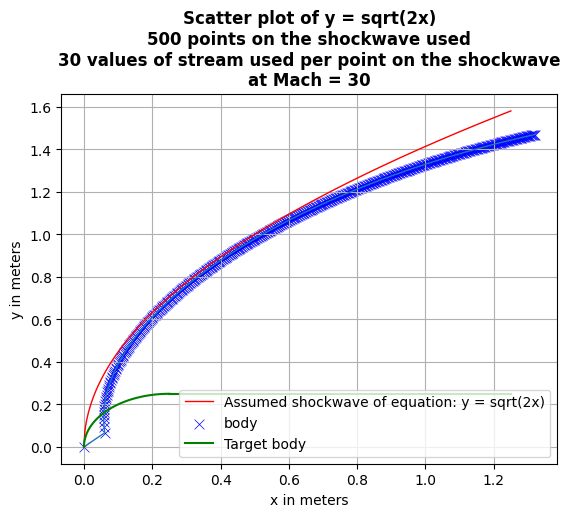

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

rho_inf = 0.0886
M = 30
gamma = 1.4
r = 287
T_inf = 216.65
v_inf = M*math.sqrt(gamma*r*T_inf)
p_inf = 5480
s_inf = 710.57 #J/mol/K
cp = 1005 #J/kg/K
r = 287.05 #J/kg/K
limit = 1.25

#definition of phi_values, gradient, shock_angle
num_points_shock = 500
num_points_phi = 30
x_values = np.linspace(0, limit, num_points_shock)
y_values = np.sqrt(2*x_values)
gradient = 1/(np.sqrt(2*x_values))
shock_angle = np.arctan(gradient) #in radians
phi_order = [num_points_phi,]+[i for i in range(1,num_points_phi)]
phi_values = [[{"value of phi": j*(y_values[i]*v_inf*rho_inf)/num_points_phi} for j in phi_order] 
              for i in range(num_points_shock)] #each column represents a unique streamline
df_phi_values = pd.DataFrame(phi_values)
new_column_names = [f"phi{i+1}" for i in range(len(df_phi_values.columns))]  # Generate new column names
df_phi_values.columns = new_column_names
# print(df_phi_values.iloc[45,23]['value of phi']) #remember that indices are zero based
df = pd.DataFrame({
    'x': x_values,
    'y': y_values,
    'gradient': gradient,
    'shock_angle': shock_angle,
})
df = pd.concat([df, df_phi_values], axis=1)

#definition of u and pressure values
df['u'] = [v_inf*math.cos(i) for i in df['shock_angle']] #in radians
df['p1'] = [p_inf*(1+2*gamma*(M**2*(math.sin(a))**2-1)/(gamma+1)) for a in df['shock_angle']]
df['Rs'] = [abs(((2*x)**(3/2))*(1 + 1 / x) ** (3 / 2)) if x != 0 else float('inf') for x in df['x']]
df['rho_1'] = [rho_inf*(1+((gamma+1)*M**2*(math.sin(a))**2)/((gamma-1)*M**2*(math.sin(a))**2+2)) for a in df['shock_angle']]
df['T1'] = [T_inf*(1+2*gamma*(M**2*(math.sin(a))**2-1)/(gamma+1))/((1+((gamma+1)*M**2*(math.sin(a))**2)/((gamma-1)*M**2*(math.sin(a))**2+2))) for a in df['shock_angle']]

#define columns filled with 0 for y_b and column for x and y coordinate of body grid
df['y_b'] = 0
df['x_body'] = 0
df['y_body'] = 0

for i in range(num_points_shock):
    phi_1 = df.at[i, 'phi1']['value of phi']
    u1 = df.at[i, 'u']
    Rs = df.at[i, 'Rs']
    p1 = df.at[i, 'p1']
    rho_1 = df.at[i, 'rho_1']
    angle_at_point1 = df.at[i, 'shock_angle']
    x_at_point1 = df.at[i, 'x']
    y_at_point1 = df.at[i, 'y']
    for j in range(2,num_points_phi+1):
        column_name = f'phi{j}'  
      
        phi_j = df.at[i, column_name]['value of phi']        
        df.at[i, column_name][f"p{j}"] = p1 + (u1/Rs)*(phi_j - phi_1) #add new pressure grid values
        p = df.at[i, column_name][f"p{j}"]
        df.at[i, column_name]["height_y'"] = df.at[i, column_name]['value of phi']/rho_inf/v_inf #add new height grid values y,corresponding to point on the shockwave
        height_y_behindshock = df.at[i, column_name]["height_y'"]
        df.at[i, column_name]["beta'"] = math.atan(1/height_y_behindshock) #convert gradient to angle, beta right behind shockwave
        beta = df.at[i, column_name]["beta'"]
        df.at[i, column_name]["p'_behind_shock"] = p_inf*(1+2*gamma*(M**2*(math.sin(beta))**2-1)/(gamma+1))
        df.at[i, column_name]["T'_behind_shock"] = T_inf*(1+2*gamma*(M**2*(math.sin(beta))**2-1)/(gamma+1))/((1+((gamma+1)*M**2*(math.sin(beta))**2)/((gamma-1)*M**2*(math.sin(beta))**2+2)))
        p_prime = df.at[i, column_name]["p'_behind_shock"]
        T_prime = df.at[i, column_name]["T'_behind_shock"]
        df.at[i, column_name]["delta_s"] = cp*math.log(T_prime/T_inf)-(r*math.log(p_prime/p_inf))
        delta_s = df.at[i, column_name]["delta_s"]

        #Defining temperature and density and velocities for each grid point using enthalpy relations
        df.at[i, column_name][f"T{j}"] = T_inf*math.exp((delta_s+r*math.log(p/p_inf))/cp)
        T = df.at[i, column_name][f"T{j}"]
        df.at[i, column_name][f"rho{j}"] = p/(r*T)
        rho = df.at[i, column_name][f"rho{j}"]
        u_grid = math.sqrt(2*(cp*(T_inf-T)+(v_inf**2)/2))
        df.at[i, column_name][f"u{j}"] = u_grid
        df.at[i, column_name][f"1/(rho*u{j})"] = 1/(math.sqrt(2*(cp*(T_inf-T)+(v_inf**2)/2))*rho)
    
    #Calculate y_b the distance between shock wave and body
    grid_y = [1/(u1*rho_1),]+[df.at[i, f"phi{k}"][f"1/(rho*u{k})"] for k in range(2,num_points_phi+1)]
    grid_x = [phi_1,] + [df.at[i, f"phi{k}"]["value of phi"] for k in range(2,num_points_phi+1)]
    y_b = abs(np.trapz(grid_y, grid_x))
    df.at[i, 'y_b'] = y_b
    #definition of body grid
    df.at[i, 'x_body'] = x_at_point1 + y_b*math.sin(angle_at_point1)
    df.at[i, 'y_body'] = y_at_point1 - y_b*math.cos(angle_at_point1)

#save data to csv file: 
df.to_csv('data3.csv', index=False)

############################################
##################PLOTTING##################
############################################
# Create scatter plot of shockwave
x_shock_forplotonly = np.linspace(0, limit, num_points_shock)
y_shock_forplotonly = np.sqrt(2*x_values)
plt.plot(x_shock_forplotonly, y_shock_forplotonly, color='red', linewidth=1, label='Assumed shockwave of equation: y = sqrt(2x)')
# Create scatter plot of body
plt.scatter(df['x_body'], df['y_body'], color='blue', s=50, marker='x', label='body', linewidths=0.5)
plt.plot(df['x_body'], df['y_body'], linestyle='-', linewidth=1)
# plt.text(0.5, 1.5, f'{num_points_shock} points on the shockwave used\n{num_points_phi} values of stream used per point on the shockwave', fontsize=12, ha='center', va='center')
#plot target body
center_x, center_y = 0.25, 0
radius = 0.25
theta = np.linspace(0, np.pi / 2, 100)
x_circle = center_x - radius * np.cos(theta)
y_circle = center_y + radius * np.sin(theta)
x_line = [0.25, 1.25]
y_line = [0.25, 0.25]
plt.plot(x_circle, y_circle, label='Target body', color='green')
plt.plot(x_line, y_line, color='green')

plt.xlabel('x in meters')
plt.ylabel('y in meters')
plt.title('Scatter plot of y = sqrt(2x)'+'\n'+f'{num_points_shock} points on the shockwave used\n{num_points_phi} values of stream used per point on the shockwave'+'\n'+f'at Mach = {M}', weight='bold')
plt.legend()
plt.grid(True)
plt.show()